In [33]:
import uproot
import awkward as ak
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
plt.style.use(hep.style.ROOT)

typelist = ['ch+', 'ch-', 'nh', 'ph', 'el+', 'el-', 'mu+', 'mu-']

def make_subplot(ax, data, evt, force_xylim=None):
    # default plotting configuration
    color_dict_ = {'ch': 'C0', 'nh': 'mediumpurple', 'ph': 'orange', 'el': 'red', 'mu': 'green'}
    color_dict = color_dict_.copy()
    color_dict.update({k+'+': color_dict_[k] for k in color_dict_})
    color_dict.update({k+'-': color_dict_[k] for k in color_dict_})
    color_default =  'C0'
    if data.get('id') is None:
        data['id'] = ['default'] * len(data['pt'])
    ptfunc = lambda x: np.sqrt(x)/20
    alpha = 0.3
    # svs
    for eta, phi, pt, d3d in zip(data['sv_eta'], data['sv_phi'], data['sv_pt'], data['sv_d3d']):
        ptdraw = np.sqrt(pt)/20
        ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 4, radius=ptdraw, clip_on=True, alpha=alpha, **make_color_args(0, d3d, point_type='sv')))
    # particles
    for eta, phi, pt, id, d3d in zip(data['eta'], data['phi'], data['pt'], data['id'], data['d3d']):
        ptdraw = ptfunc(pt)
        if id in [4,5]:
            ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 3, radius=ptdraw, clip_on=True, alpha=alpha, edgecolor='black', **make_color_args(id, d3d)))
        elif id in [6,7]:
            ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 3, radius=ptdraw, orientation=np.pi, clip_on=True, alpha=alpha, edgecolor='black', **make_color_args(id, d3d)))
        elif id in [3]:
            ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 5, radius=ptdraw, clip_on=True, alpha=alpha, **make_color_args(id, d3d)))
        else:
            ax.add_patch(plt.Circle((eta, phi), ptdraw, clip_on=True, alpha=alpha, **make_color_args(id, d3d)))

    add_gen_content(ax, evt, plot_reco=True)
    
    max_ang = force_xylim if force_xylim else max(max(abs(data['eta'])), max(abs(data['phi'])))
    # make square plot centered at (0,0)
    ax.set_xlim(-max_ang, max_ang); ax.set_ylim(-max_ang, max_ang)
    ax.set_xlabel(r'$\Delta\eta$'); ax.set_ylabel(r'$\Delta\phi$')
    ax.set_aspect('equal')
    return max_ang

def make_color_args(id, d3d, point_type='particle'):
    if point_type == 'particle':
        # color = color_fader('C0', 'magenta', d3d)
        # color = color_fader('#a8ddb5', '#084081', d3d)
        color = color_fader('#74c476', '#081d58', d3d)
        # color = color_fader('seagreen', 'darkblue', d3d)
    elif point_type == 'sv':
        color = color_fader('orange', 'lightcoral', d3d)
    if id in [2, 3]:
        return {'edgecolor': color, 'linewidth': 2, 'fill': False}
    else:
        return {'facecolor': color}
    # if id in [1, 5, 7]:
    #     return {'edgecolor': color, 'fill': False, 'hatch':'**'}
    # else:
    #     return {'facecolor': color}

def color_fader(c1, c2, mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    mix = min(1., mix)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

def add_gen_content(ax, tree, plot_reco=True):
    # default plotting configuration
    f = lambda x: np.sqrt(x)/20
    alpha = 0.3

    def color_opt(color, fill=True):
        if fill:
            return {'facecolor': color}
        else:
            return {'edgecolor': color, 'linewidth': 2, 'fill': False, 'hatch': '///'}
    # # gen higgs/higgs
    # for pt, eta, phi in zip(tree.GENH_pt, tree.GENH_eta, tree.GENH_phi):
    #     ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 4, radius=f(pt), clip_on=True, alpha=alpha, **color_opt('grey', fill=False)))
    # if plot_reco:
    #     for pt, eta, phi in zip(tree.H_pt, tree.H_eta, tree.H_phi):
    #         ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 4, radius=f(pt), clip_on=True, alpha=alpha, **color_opt('grey', fill=True)))
    # # gen lep/leps
    # for i, (pt, eta, phi) in enumerate(zip(tree.GENlep_pt, tree.GENlep_eta, tree.GENlep_phi)):
    #     lep_color = 'firebrick' if i in [0, 1] else 'violet'
    #     ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 3, radius=f(pt), clip_on=True, alpha=alpha, **color_opt(lep_color, fill=False)))
    # if plot_reco:
    #     for i, (pt, eta, phi) in enumerate(zip(tree.lep_pt, tree.lep_eta, tree.lep_phi)):
    #         ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 3, radius=f(pt), clip_on=True, alpha=alpha, **color_opt(lep_color, fill=True)))
    # partons/hadrons
    # for pt, eta, phi, isc in zip(tree.GENparton_pt, tree.GENparton_eta, tree.GENparton_phi, tree.GENparton_isc):
    #     color = 'deepskyblue' if isc else 'purple'
    #     ax.add_patch(plt.Circle((eta, phi), radius=f(pt), clip_on=True, alpha=alpha, **color_opt(color, fill=False)))
    for pt, eta, phi, isc in zip(tree.GENhadron_pt, tree.GENhadron_eta, tree.GENhadron_phi, tree.GENhadron_isc):
        color = 'deepskyblue' if isc else 'purple'
        ax.add_patch(plt.Circle((eta, phi), radius=f(pt), clip_on=True, alpha=alpha, **color_opt(color, fill=True)))

In [39]:
df = uproot.lazy('/data/pku/home/licq/cH/zz_v2/samples/gen_training_dataset/v2-pfcands/HC_4FS.root')
avail_inds = ak.local_index(df.pass_fiducial)[df.pass_fiducial]

In [40]:
i = 3
evt = df[avail_inds[i]]

evt.pfcand_eta

<Array [2.62, 2.44, 2.26, ... -2.75, -3.26] type='146 * float32'>

6

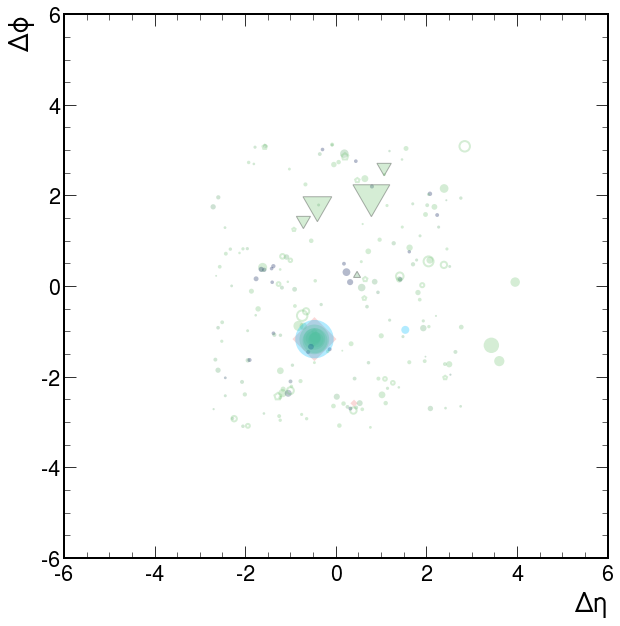

In [41]:
i = 4
evt = df[avail_inds[i]]

data = {}
data['pt'] = evt.pfcand_pt
data['eta'] = evt.pfcand_eta
data['phi'] = evt.pfcand_phi
data['d3d'] = np.tanh(np.hypot(evt.pfcand_dxy, evt.pfcand_dz))
part_type = np.concatenate([
    [(evt.pfcand_isChargedHad==1) & (evt.pfcand_charge==1)],
    [(evt.pfcand_isChargedHad==1) & (evt.pfcand_charge==-1)],
    [evt.pfcand_isNeutralHad==1],
    [evt.pfcand_isGamma],
    [(evt.pfcand_isEl==1) & (evt.pfcand_charge==1)],
    [(evt.pfcand_isEl==1) & (evt.pfcand_charge==-1)],
    [(evt.pfcand_isMu==1) & (evt.pfcand_charge==1)],
    [(evt.pfcand_isMu==1) & (evt.pfcand_charge==-1)],
], axis=0)
data['id'] = np.argmax(part_type.T, axis=1) # better

## sv
data['sv_pt'] = evt.sv_pt
data['sv_eta'] = evt.sv_eta
data['sv_phi'] = evt.sv_phi
# data['sv_d3d'] = np.tanh(evt.sv_d3d)
data['sv_d3d'] = ak.ones_like(evt.sv_phi)

assert len(data['eta'] == data['id'])
fig, ax = plt.subplots(figsize=(10, 10))
make_subplot(ax, data, evt, force_xylim=6)


In [32]:
evt.cleanedjet_pt

<Array [56.4, 34.9] type='2 * float32'>